## Setup environment

In [1]:
from neo4j import GraphDatabase
from branca.colormap import LinearColormap
import folium
import geopandas as gpd 
import matplotlib as plt
import matplotlib.pyplot as pyplot
import branca.colormap as cm
import numpy as np

In [2]:
url = "bolt://neo4j"
username = "neo4j"
password = "admin"

driver = GraphDatabase.driver(url, auth=("neo4j", "admin"), encrypted=False)

In [64]:
def get_step_legend(max_value):
    return [ 0, (max_value * 0.05), (max_value * 0.2) , (max_value * 0.4), (max_value * 0.7), max_value]

def get_step_legend_1(data, num_categories):
    data_min = np.min(data)
    data_max = np.max(data)
    data_std = np.std(data)

    category_width = (data_max - data_min) / num_categories
    category_boundaries = [data_min + i * category_width for i in range(num_categories)]
    category_boundaries.append(data_max)

    return category_boundaries

## Load coordinates from Mongo to Neo4j

In [24]:
query = """
    MATCH (n) detach delete n
"""
with driver.session() as session:
    session.run(query)
    print("Esecuzione della query completata")

Esecuzione della query completata


In [25]:
query = """
    CALL apoc.mongo.find('mongodb://mongo:27017/mydb.polygons', {name: 'anderlecht'}) YIELD value 
    WITH value.streets AS streets 
    UNWIND range(0, 100) AS street_id 
    WITH streets[street_id] AS current, street_id
    UNWIND range(0, size(current.coords) - 2) AS coord_id 
    WITH current.coords[coord_id] AS current_c, current.coords[coord_id + 1] AS next_c, street_id
    MERGE (c1:Coordinate {latitude: current_c[1], longitude: current_c[0]}) 
    MERGE (c2:Coordinate {latitude: next_c[1], longitude: next_c[0]}) 
    MERGE (c1)-[n:NEXT]->(c2) ON CREATE SET n.street_id = street_id ON MATCH SET n.street_id = street_id
"""
with driver.session() as session:
    session.run(query)
    print("Esecuzione della query completata")

Esecuzione della query completata


## Functions for data population

### Get traffic info by month

In [45]:
collection = "anderlecht-period-1"
date = "2019-01" 

In [46]:
def get_data_by_month(collection, date):
    query = f"""
        CALL apoc.mongo.find('mongodb://mongo:27017/mydb.{collection}') yield value
        UNWIND value AS street
        MATCH (n1:Coordinate)-[r:NEXT]->(n2:Coordinate)
        WHERE r.street_id = street.id
        SET r.traffic = [event IN street.events WHERE event.date = '{date}' | event][0].traffic_sum
        SET r.date = '{date}'
    """
    with driver.session() as session:
        session.run(query)
        result = session.run("MATCH (:Coordinate)-[r:NEXT]->(:Coordinate) WHERE r.traffic is not null RETURN r.traffic AS traffic")
        traffic_values = [record["traffic"] for record in result]
        print(f'Esecuzione della query per {date} completata')
    return traffic_values

### Get traffic info by day

In [47]:
collection = "anderlecht-period-1"
month = "2019-01" 
day = "2019-01-06"

In [48]:
def get_data_by_day(collection , month, day):
    query = f"""
        CALL apoc.mongo.find('mongodb://mongo:27017/mydb.{collection}') yield value
        UNWIND value AS street
        MATCH (n1:Coordinate)-[r:NEXT]->(n2:Coordinate)
        WHERE r.street_id = street.id
        WITH r, street, [event IN street.events WHERE event.date = '{month}' | event][0] as month
        WITH r, street, [event IN month.events WHERE event.date = '{day}' | event][0] as day
        SET r.traffic = day.traffic_sum
        SET r.velocity = day.velocity_mean
    """
    with driver.session() as session:
        session.run(query)
        result = session.run("MATCH (:Coordinate)-[r:NEXT]->(:Coordinate) WHERE r.traffic is not null RETURN r.traffic AS traffic")
        traffic_values = [record["traffic"] for record in result]
        print(f'Esecuzione della query per {date} completata')
    return traffic_values

## Map analysis

In [71]:
query = """
    MATCH (c1:Coordinate)-[n:NEXT]->(c2:Coordinate)
    WHERE n.traffic is not null
    RETURN c1.latitude AS c1_lat, c1.longitude AS c1_lon, c2.latitude AS c2_lat, c2.longitude AS c2_lon, n.traffic as traffic
"""

with driver.session() as session:
    result = session.run(query)
    traffic = [(record["c1_lat"], record["c1_lon"], record["c2_lat"], record["c2_lon"], record["traffic"]) for record in result]
    print("Esecuzione della query completata")
    
max_value = np.max(traffic)
step_legend = get_step_legend(max_value)

Esecuzione della query completata


In [72]:
colormap_dept = cm.StepColormap(
    colors=['#00ae53', '#bfd947', '#f1c232',
            '#ee7b15', '#ee0028'],
    vmin = 1,
    vmax = max_value,
    index=step_legend)

def get_color(value):
    if value <= step_legend[1]:
        return '#00ae53'
    elif value <= step_legend[2]:
        return '#bfd947'
    elif value <= step_legend[3]:
        return '#f1c232'
    elif value <= step_legend[4]:
        return '#ee7b15'
    else:
        return '#ee0028'

In [73]:
m = folium.Map(location=[50.832697, 4.294337], zoom_start=14, tiles='cartodbpositron',  control_scale=True, zoom_control=False, dragging=False, scrollWheelZoom=False)
for coords in traffic:
    color = get_color(coords[4])
    folium.PolyLine([(coords[0], coords[1]), (coords[2], coords[3])], color=color, weight=3).add_to(m)

colormap_dept.caption = 'Traffico'
colormap_dept.add_to(m)
m

## Case study : traffic comparison by month

In [77]:
collection = "anderlecht-period-1"
day = "2019-01-06"

traffic_01 = get_data_by_month(collection, "2019-01")
traffic_02 = get_data_by_month(collection, "2019-02")

Esecuzione della query per 2019-01 completata
Esecuzione della query per 2019-02 completata


### Analysis graphs

In [81]:
max_value = np.max([np.max(traffic_01), np.max(traffic_02)])
step_legend = get_step_legend(max_value)
labels = 'Traffico elevato', 'Traffico moderato', 'Traffico scorrevole', 'Scorrevole'
colors = [ '#ee0028', '#ee7b15',  '#f1c232',  '#bfd947', '#00ae53']

def divide_traffic_by_class(values):
    value_20, value_40, value_60, value_80 = 0, 0, 0 , 0
    for row in values:
        if row < step_legend[1]:
            value_20 += 1
        elif row < step_legend[2]:
            value_40 += 1
        elif row < step_legend[3]:
            value_60 += 1
        elif row >= step_legend[3]:
            value_80 += 1
    return [value_80, value_60, value_40, value_20]

traffic_01_class = divide_traffic_by_class(traffic_01)
traffic_02_class = divide_traffic_by_class(traffic_02)

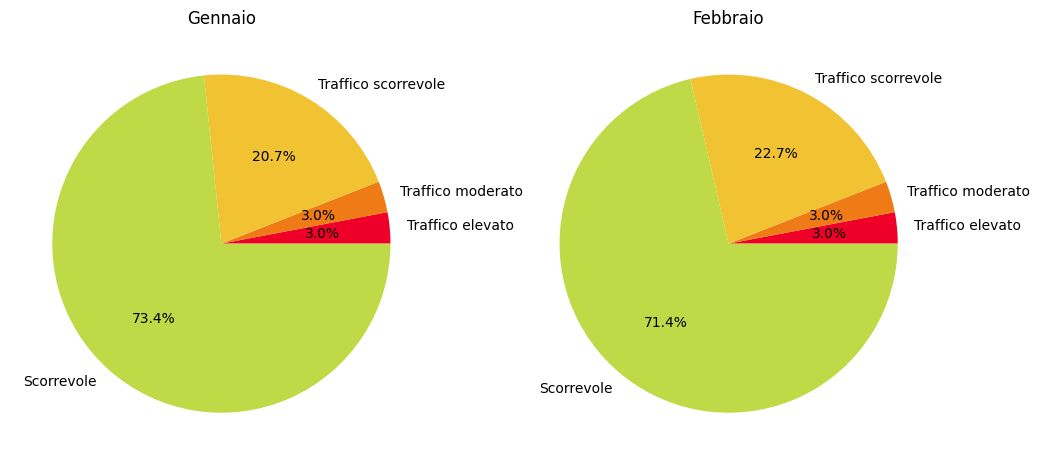

In [82]:
# specifico righe e colonne
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12, 10))


ax1.pie(traffic_01_class, labels=labels,  autopct='%1.1f%%', colors=colors)
ax1.set_aspect('equal')  # Per avere un aspetto circolare del grafico a torta
ax1.set_title('Gennaio')


ax2.pie(traffic_02_class, labels=labels,  autopct='%1.1f%%', colors=colors)
ax2.set_aspect('equal')
ax2.set_title('Febbraio')

pyplot.show()

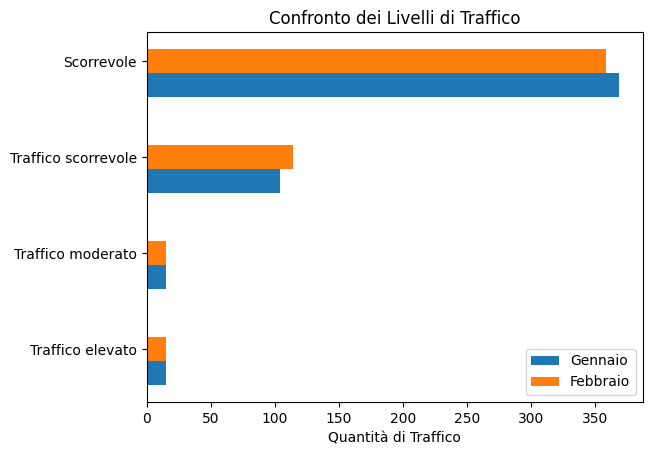

In [83]:
# Posizioni delle barre
bar_positions = np.arange(len(labels))

# Larghezza delle barre
bar_width = 0.25

# Creazione del grafico a barre
pyplot.barh(bar_positions, traffic_01_class, height=bar_width, label='Gennaio')
pyplot.barh(bar_positions + bar_width, traffic_02_class, height=bar_width, label='Febbraio')
#plt.barh(bar_positions + 2 * bar_width, traffic_3, height=bar_width, label='Traffic 3')

# Etichette degli assi
pyplot.yticks(bar_positions + bar_width, labels)
pyplot.xlabel('Quantità di Traffico')

# Titolo del grafico
pyplot.title('Confronto dei Livelli di Traffico')

# Legenda
pyplot.legend()

# Mostrare il grafico
pyplot.show()
